# Transient Universe: Nested Sampling

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dynesty
from dynesty import utils as dyfunc, plotting as dyplot

import scipy.stats as stats
import corner


#Nice figures
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [22]:
data = np.load('../solutions/transient.npy')

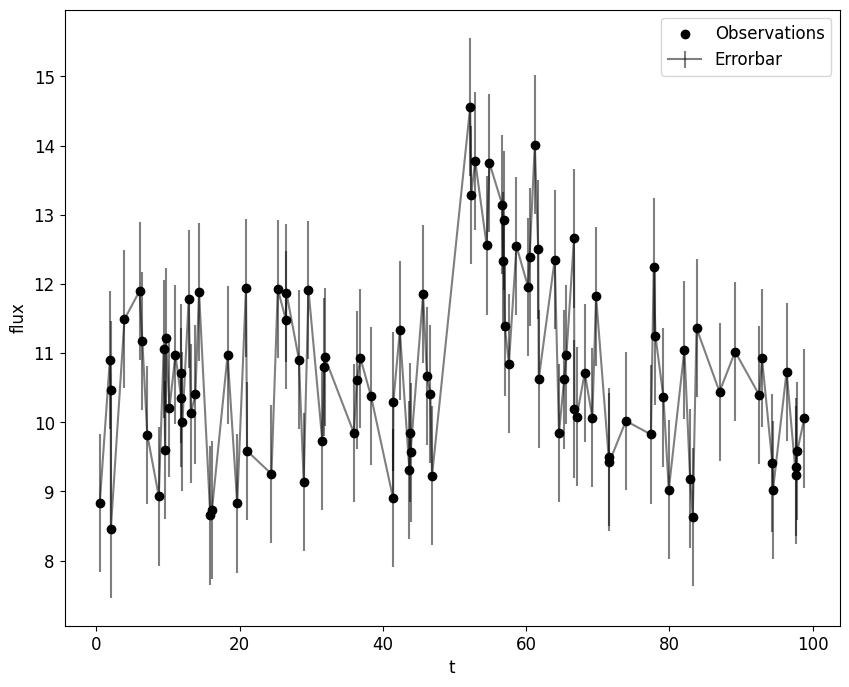

In [77]:
#Unpacking data
t, flux, flux_err = data.T

#Plotting with errors
plt.scatter(t, flux, c='k', label='Observations')
plt.errorbar(t, flux, yerr=flux_err, c='k', label='Errorbar', alpha=0.5)
plt.xlabel('t')
plt.ylabel('flux')
plt.legend()
plt.show()

In [99]:
#Function modeling Signal: Noise + Exponential decay
def burst_model(parameters, t):

    b, t_0, A, alpha = parameters

    return np.where(t<t_0, b, b + A * np.exp(-alpha * (t - t_0)))

#Function modeling Signal: Gaussian Profile
def gauss_model(parameters, t):

    b, t_0, A, sigma = parameters

    prediction = b + A * np.exp( - ((t - t_0)**2  / (2 * ((sigma)**2))))

    return prediction

In [79]:
def burst_loglike(theta, data):
    t, flux, flux_err = data.T

    #Computing theoretical flux coming from burst model
    flux_th = burst_model(theta, t)

    #Gaussian Log-Likelihood -> Distance from theoretical value
    logL = -0.5 * np.sum(((flux - flux_th)**2 / (flux_err)**2))

    return logL

def gauss_loglike(theta, data):
    t, flux, flux_err = data.T

    #Computing theoretical flux coming from gaussian model
    flux_th = gauss_model(theta, t)

    #Gaussian Log-Likelihood -> Distance from theoretical value
    logL = -0.5 * np.sum(((flux - flux_th)**2 / (flux_err)**2))

    return logL


#Priors boundaries
bmin, bmax = 0, 50
t0min, t0max = 0, 100
Amin, Amax = 0, 50

alphamin, alphamax = np.exp(-5), np.exp(5)
sigmamin, sigmamax = np.exp(-2), np.exp(2)

def burst_priors(theta):

    #Since we are accessing indexes, copying input array
    prior = np.array(theta)

    #Setting Priors
    prior[0] = stats.uniform(loc=bmin, scale=bmax-bmin).ppf(theta[0])
    prior[1] = stats.uniform(loc=t0min, scale=t0max-t0min).ppf(theta[1])
    prior[2] = stats.uniform(loc=Amin, scale=Amax-Amin).ppf(theta[2])

    #Burst model -> alpha prior
    prior[3] = stats.loguniform.ppf(theta[3], alphamin, alphamax)

    return prior

def gauss_priors(theta):

    #Since we are accessing indexes, copying input array
    prior = np.array(theta)

    #Setting Priors
    prior[0] = stats.uniform(loc=bmin, scale=bmax-bmin).ppf(theta[0])
    prior[1] = stats.uniform(loc=t0min, scale=t0max-t0min).ppf(theta[1])
    prior[2] = stats.uniform(loc=Amin, scale=Amax-Amin).ppf(theta[2])

    #Gaussian model -> sigma prior
    prior[3] = stats.loguniform.ppf(theta[3], sigmamin, sigmamax)

    return prior

### Burst Model Sampling

In [43]:
#Burst Model
ndim = 4
sampler = dynesty.NestedSampler(burst_loglike, 
                                burst_priors, ndim, 
                                logl_args=[data], 
                                nlive=100)

sampler.run_nested()

/var/folders/hz/p6990d5s151fqhq0n07rh8sm0000gn/T/ipykernel_63182/3527633359.py:6: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/var/folders/hz/p6990d5s151fqhq0n07rh8sm0000gn/T/ipykernel_63182/3527633359.py:6: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0, b, b + A * np.exp(-alpha * (t - t_0)))
361it [00:05, 14.75it/s, bound: 1 | nc: 3 | ncall: 3693 | eff(%):  9.775 | loglstar:   -inf < -183.192 <    inf | logz: -191.460 +/-  0.279 | dlogz: 120.403 >  0.109]     /var/folders/hz/p6990d5s151fqhq0n07rh8sm0000gn/T/ipykernel_63182/3527633359.py:6: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/var/folders/hz/p6990d5s151fqhq0n07rh8sm0000gn/T/ipykernel_63182/3527633359.py:6: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0, b, b + A * np.exp(-alpha * (t - t_0)))
381it [00:06, 43.67it/s, bound: 1 | nc: 6 | ncall: 3814 | e

In [ ]:
result = sampler.results

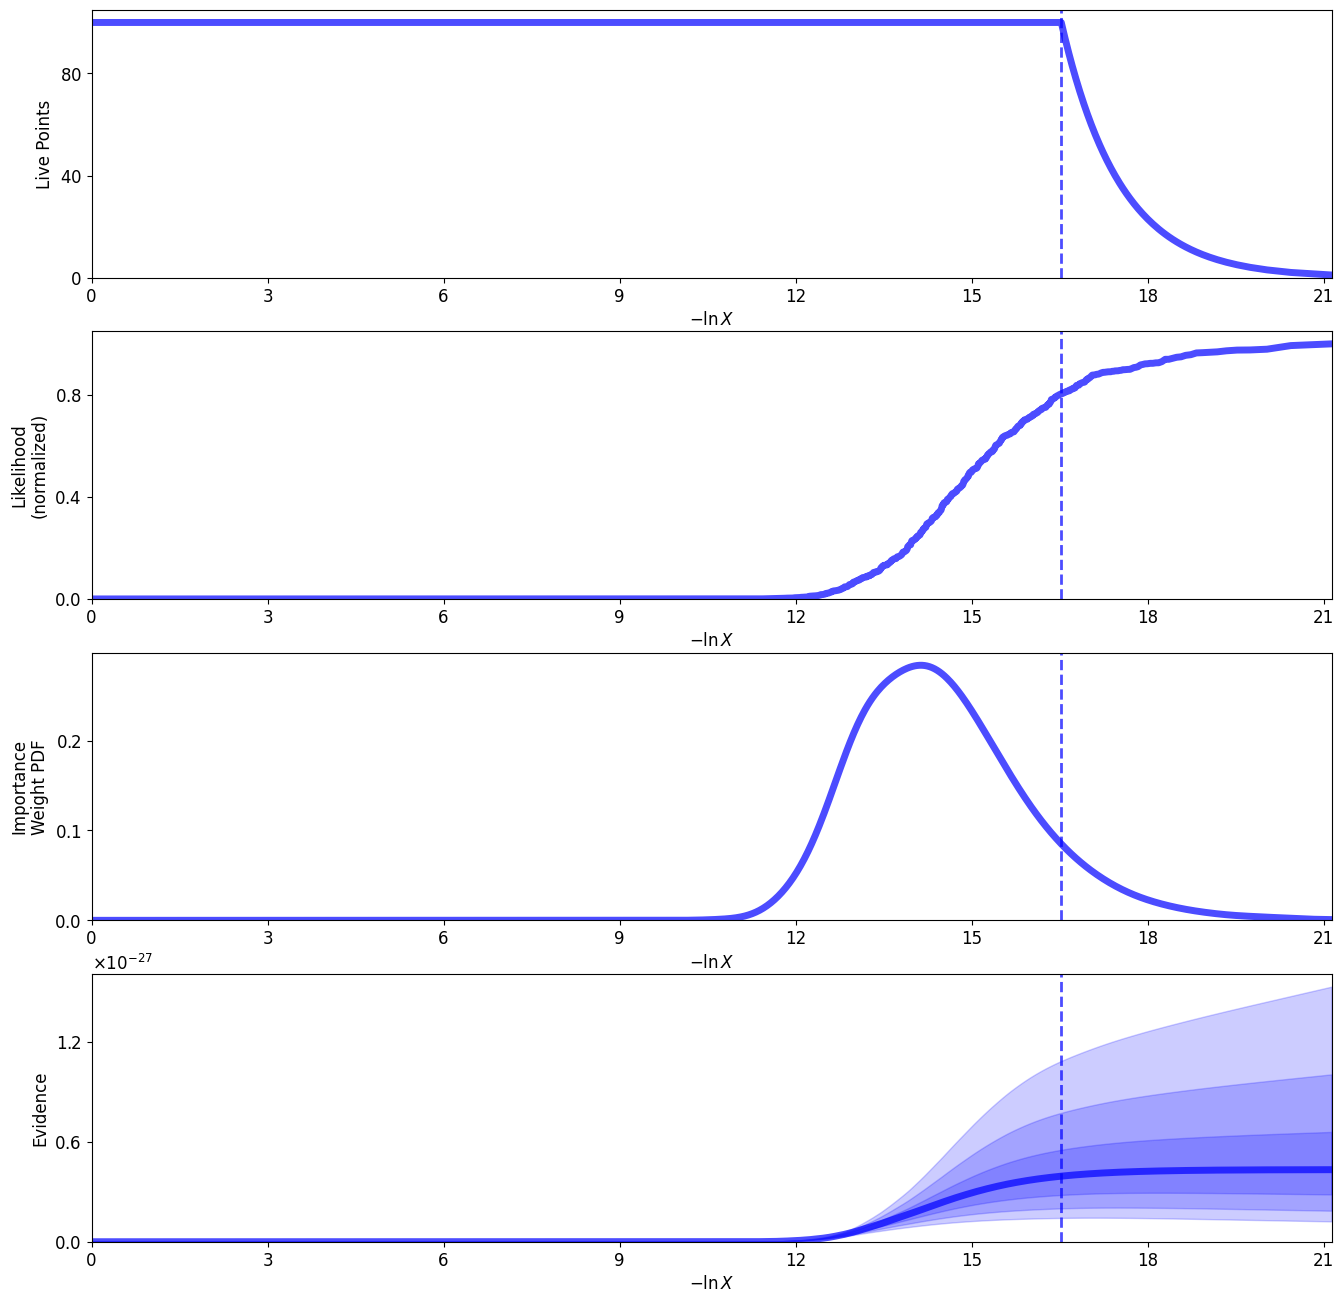

In [44]:
#Summary plots
s_fig, s_axes = dyplot.runplot(result)

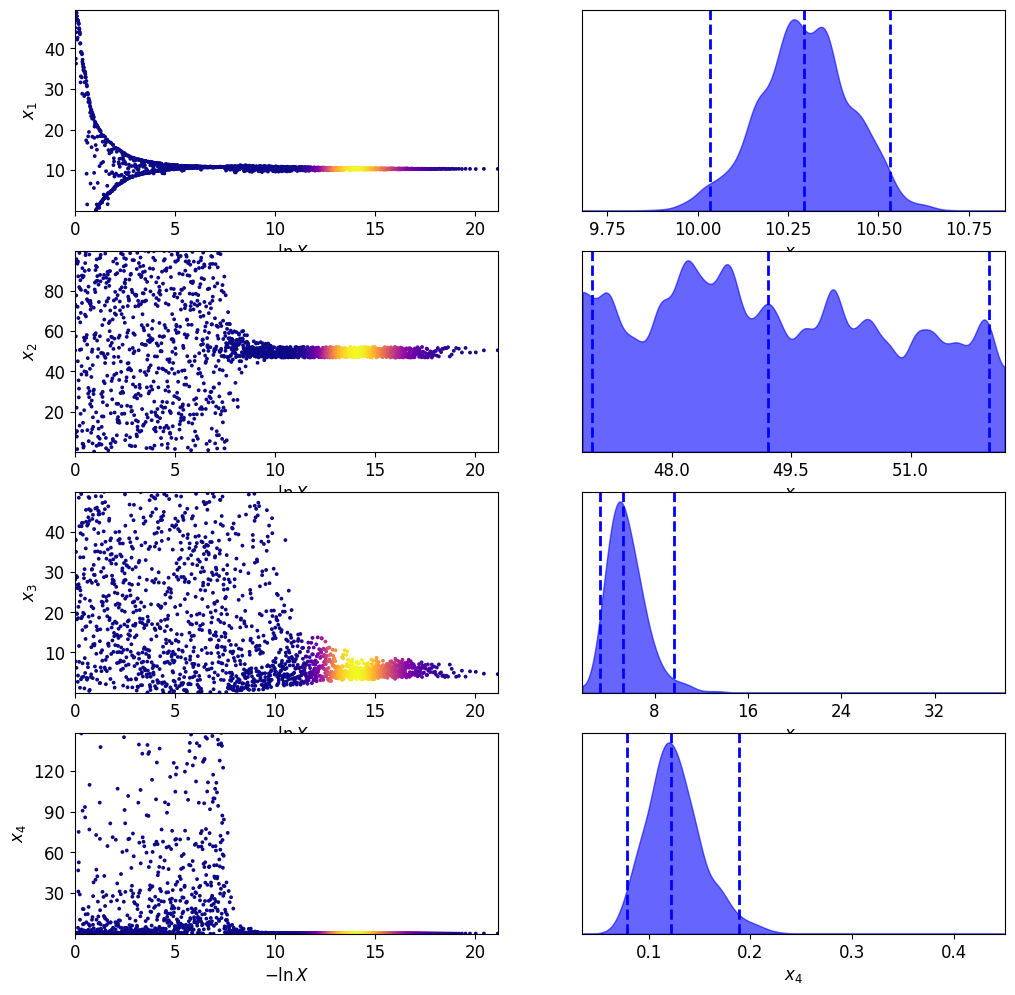

In [45]:
#Trace plots
t_fig, t_axes = dyplot.traceplot(result)

Evidence for Burst Model: 4.324121250537587e-28


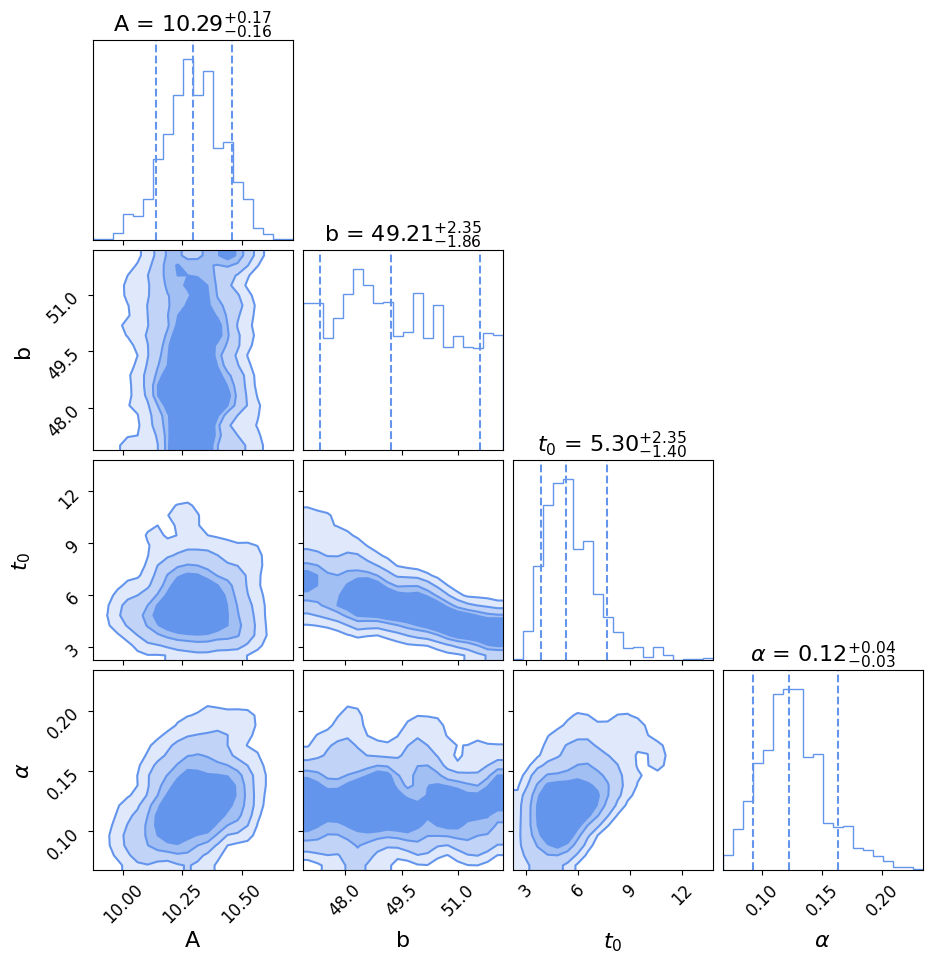

In [96]:
#Gathering Samples
samples = result.samples

#Renormalizing
weights = np.exp(result.logwt - result.logz[-1])
weighted_samples = dyfunc.resample_equal(samples, weights)

#Corner Labels
labels = ["A","b",r"$t_{0}$",r"$\alpha$"]

#Pretty-plotting arguments for corner plots
CORNER_KWARGS = dict(
    smooth = 1,
    label_kwargs = dict(fontsize=16),
    title_kwargs = dict(fontsize=16),
    labels = labels,
    quantiles = [0.05, 0.50, 0.95],
    levels = [0.50, 0.68, 0.85, 0.95],
    color = 'cornflowerblue',
    plot_density = False,
    plot_datapoints = False,
    fill_contours = True,
    show_titles = True,
    max_n_ticks = 4
)

#Saving Evidence z -> Exponentiating because sampler returns logz
burst_evidence = np.exp(result.logz[-1])

corner.corner(weighted_samples, **CORNER_KWARGS)

print('Evidence for Burst Model: {}'.format(burst_evidence))

### Comparison to MCMC corner plots

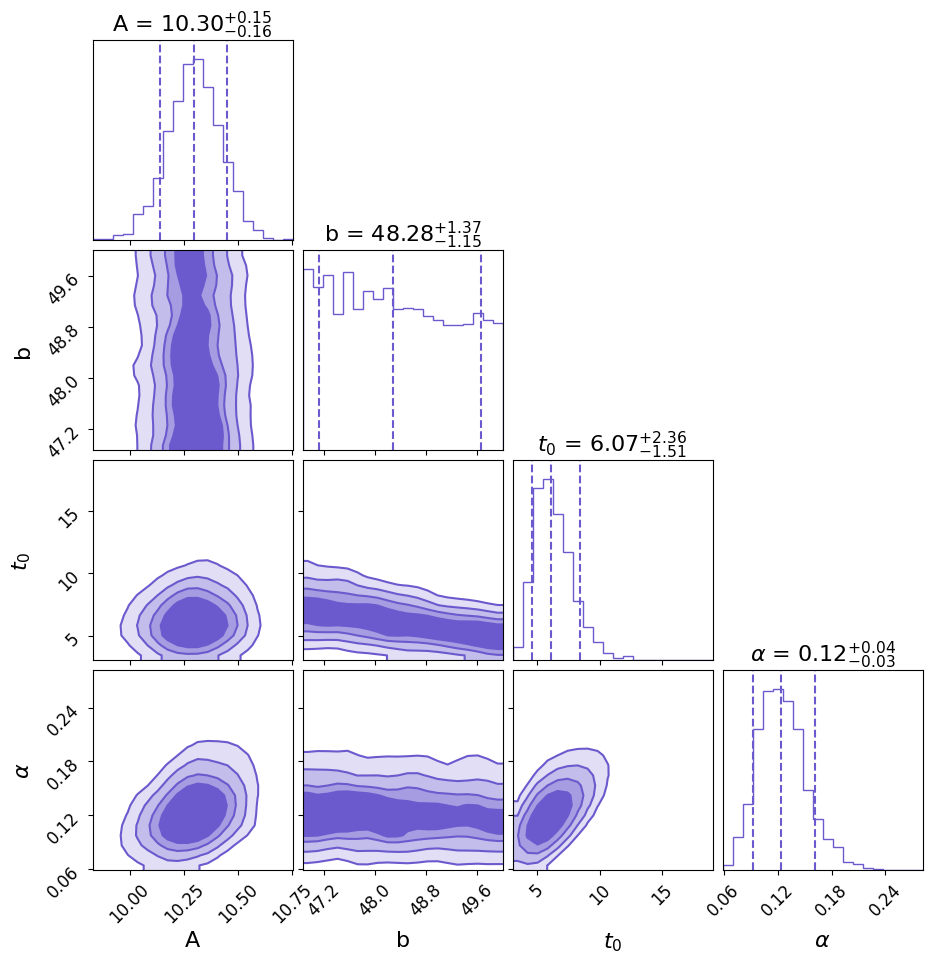

In [98]:
#Gathering MCMC Chains from Lecture11 exercise
mcmc_chains = np.load('MCMC_chains.npy')

labels = ["A","b",r"$t_{0}$",r"$\alpha$"]

#Pretty-plotting arguments for corner plots
CORNER_KWARGS = dict(
    smooth = 1,
    label_kwargs = dict(fontsize=16),
    title_kwargs = dict(fontsize=16),
    labels = labels,
    quantiles = [0.05, 0.50, 0.95],
    levels = [0.50, 0.68, 0.85, 0.95],
    color = 'slateblue',
    plot_density = False,
    plot_datapoints = False,
    fill_contours = True,
    show_titles = True,
    max_n_ticks = 4
)

corner.corner(mcmc_chains, **CORNER_KWARGS);

##### The corner plots from MCMC and Nested Sampling look very similar!!

### Gaussian Model Sampling

In [47]:
#Gaussian Model
ndim = 4
sampler = dynesty.NestedSampler(gauss_loglike,
                                gauss_priors,
                                ndim,
                                logl_args=[data],
                                nlive=100)
sampler.run_nested();

1755it [00:57, 30.40it/s, +100 | bound: 178 | nc: 1 | ncall: 30296 | eff(%):  6.143 | loglstar:   -inf < -52.404 <    inf | logz: -67.622 +/-  0.367 | dlogz:  0.001 >  0.109]


In [48]:
result2 = sampler.results

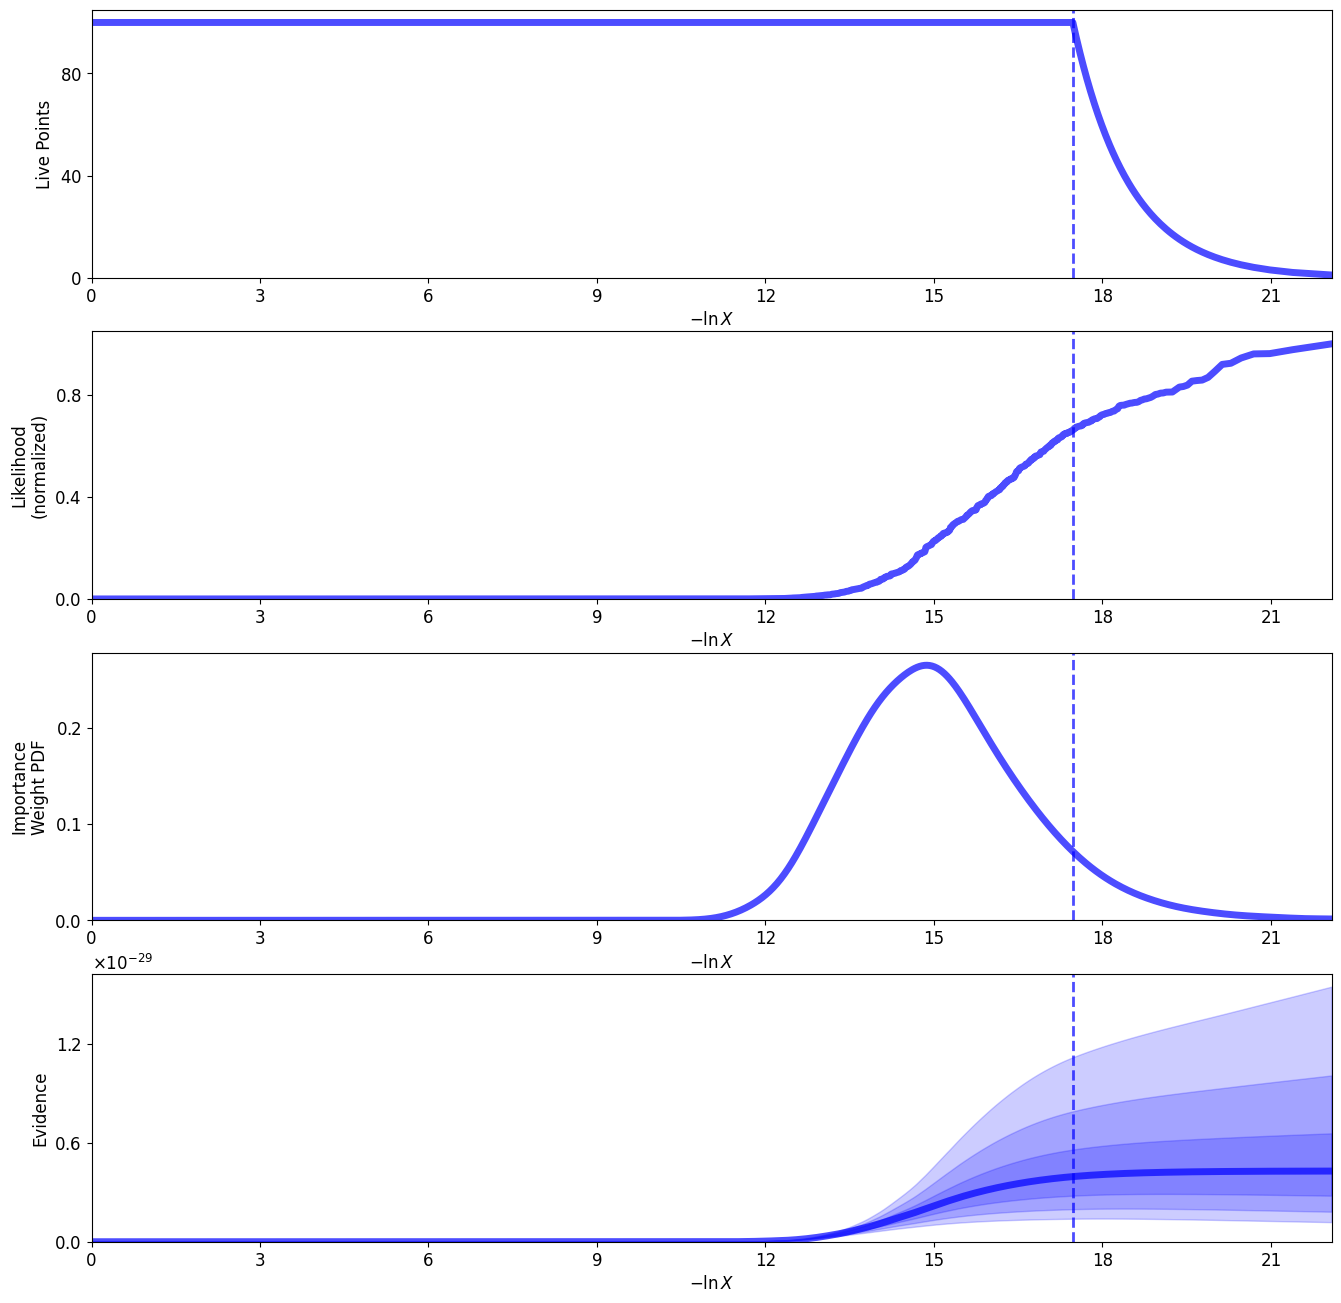

In [49]:
#Summary plots
s_fig, s_axes = dyplot.runplot(result2)

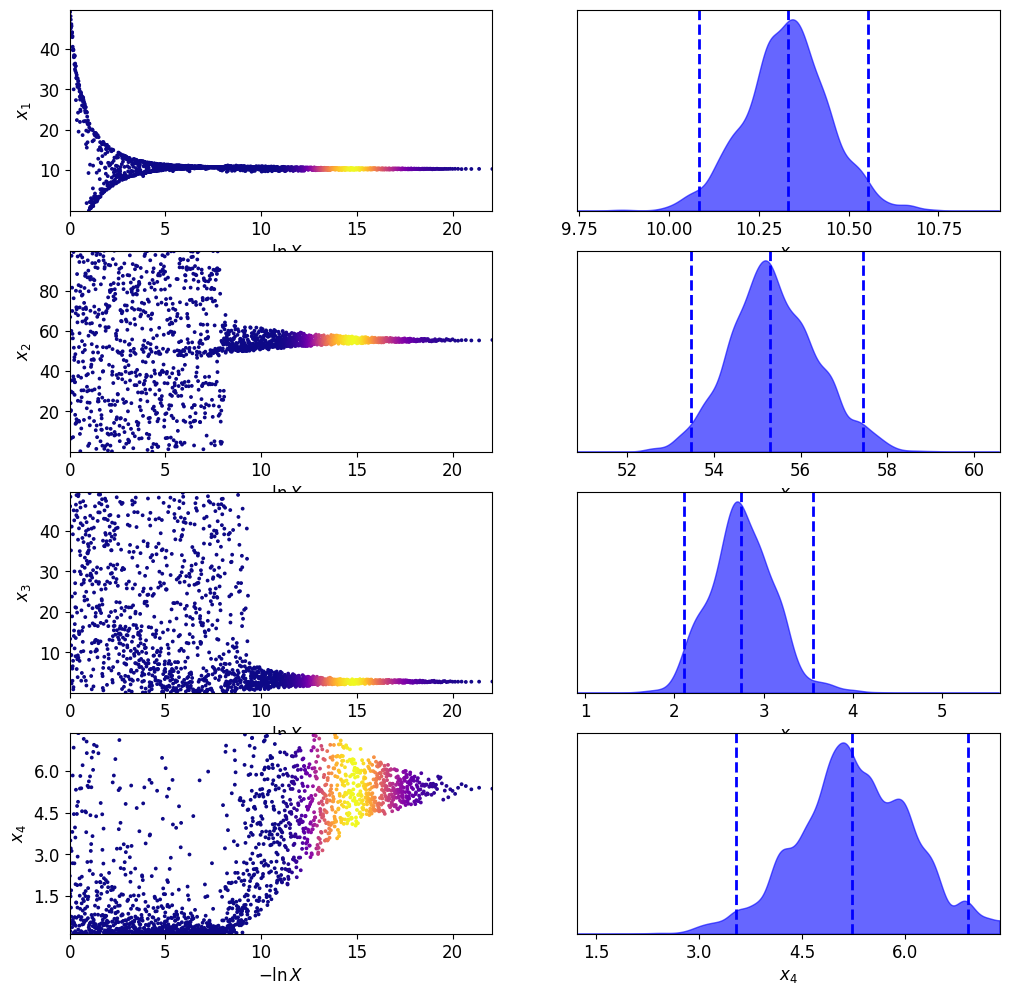

In [50]:
#Trace plots
t_fig, t_axes = dyplot.traceplot(result2)

Evidence for Gaussian Model: 4.288093251267934e-30


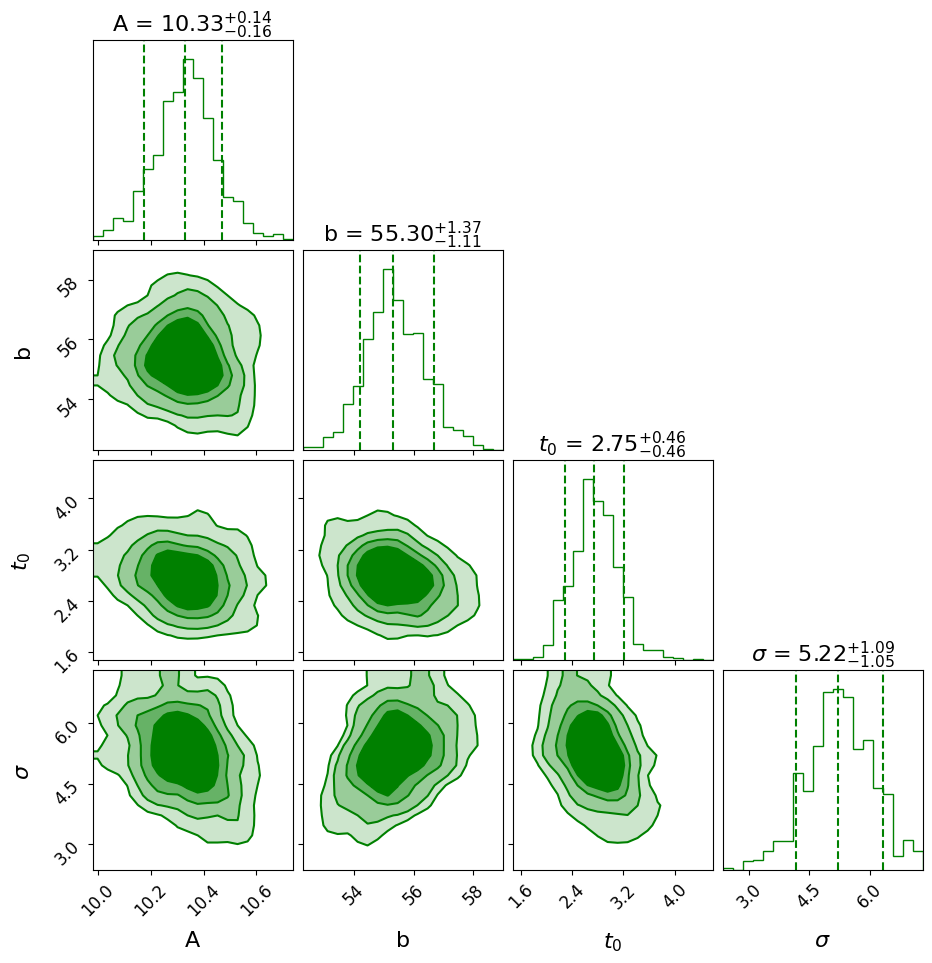

In [94]:
#Gathering Samples
samples2 = result2.samples

#Renormalizing
weights2 = np.exp(result2.logwt - result2.logz[-1])
weighted_samples2 = dyfunc.resample_equal(samples2, weights2)

#Corner Labels
labels = ["A","b",r"$t_{0}$",r"$\sigma$"]

#Pretty-plotting arguments for corner plots
CORNER_KWARGS = dict(
    smooth = 1,
    label_kwargs = dict(fontsize=16),
    title_kwargs = dict(fontsize=16),
    labels = labels,
    quantiles = [0.05, 0.50, 0.95],
    levels = [0.50, 0.68, 0.85, 0.95],
    color = 'green',
    plot_density = False,
    plot_datapoints = False,
    fill_contours = True,
    show_titles = True,
    max_n_ticks = 4
)

#Saving Evidence -> Exponentiating because sampler returns logz
gauss_evidence = np.exp(result2.logz[-1])

corner.corner(weighted_samples2, **CORNER_KWARGS)

print('Evidence for Gaussian Model: {}'.format(gauss_evidence))

In [63]:
#Comparing the two models
print('Evidence of Burst Model / Evidence of Gaussian Model: {:.3f}'.format(burst_evidence/gauss_evidence))

Evidence of Burst Model / Evidence of Gaussian Model: 100.840


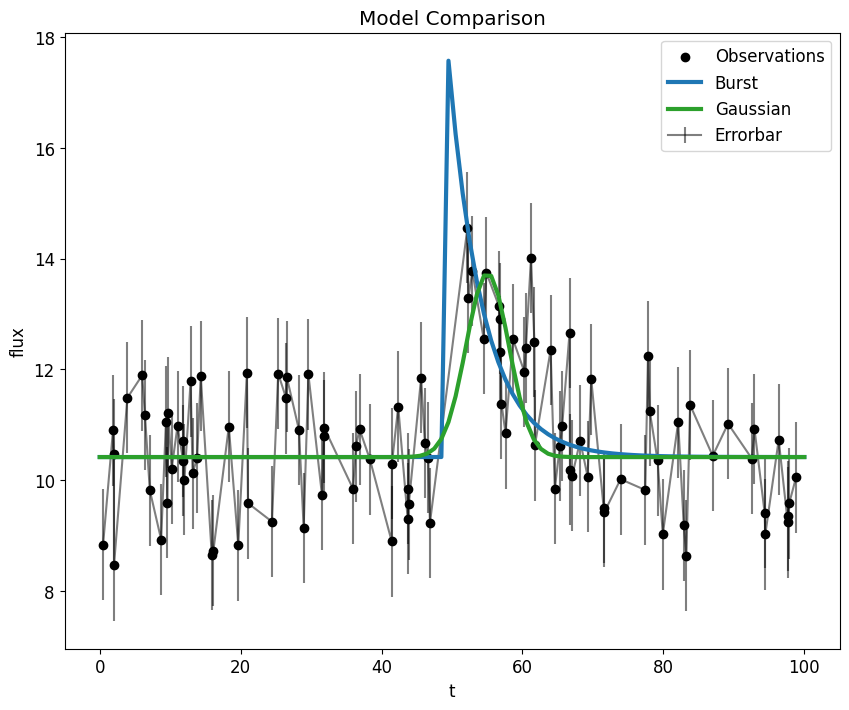

In [75]:
#Evaluating Median Values
theta_burst, theta_gauss = [], [] 

for i in range(ndim):
    theta_burst.append(np.median(samples[:, i]))
    theta_gauss.append(np.median(samples2[:, i]))

tgrid=np.linspace(0,100,100)
flux_burst = burst_model(theta_burst, tgrid)
flux_gauss = gauss_model(theta_gauss, tgrid)

#Way faster unpacking!!
t, flux, flux_err = data.T

#Plotting with errors
plt.scatter(t, flux, c='k', label='Observations', zorder=0)
plt.errorbar(t, flux, yerr=flux_err, c='k', label='Errorbar', zorder=0, alpha=0.5)
plt.plot(tgrid, flux_burst, c='C0', label='Burst', lw=3, zorder=1)
plt.plot(tgrid, flux_gauss, c='C2', label='Gaussian', lw=3, zorder=1)
plt.title('Model Comparison')
plt.xlabel('t')
plt.ylabel('flux')
plt.legend()
plt.show()